# Оценка окупаемости рекламы для привлечения пользователей

**Цель исследования** - установить причины убыточности развлекательного приложения **Procrastinate Pro+** в последние месяцы. Несмотря на увеличение рекламных расходов, рост количества привлечённых клиентов отсутствует. Необходимо описать возможные причины обнаруженных проблем и сформировать рекомендации для рекламного отдела. 

**Ход исследования**

У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей. Исследование будет разбито на следующие этапы:

1. [**Обзор/предобработка данных**](#overview)

Загрузка данных о визитах, заказах и расходах в переменные. Оптимизация данных для анализа. Проверка типов данных, пропусков и ошибок.
 
2. [**Написание функций для расчёта бизнес-показателей**](#func)

Формирование функций для расчета и анализа показателей **LTV**, **ROI**, **удержания** и **конверсии**, которые будут использованы для оценки качества клиентов.

3. [**Исследовательский анализ данных**](#EDA)

Построение профилей пользователей, в т.ч. определение минимальной и максимальной даты привлечения - это будет использовано для расчёта бизнес-показателей.

Также будут даны ответы на вопросы:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?.

4. [**Анализ маркетинговых действий**](#marketing)

Находим ответы на вопросы, касающихся маркетинга приложения:

- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

5. [**Оценка окупаемости рекламы для привлечения пользователей**](#ad_roi)

Оцениваем общую окупаемость, удержание и конверсию, а также в разрезе стран, устройств и каналов привлечения.

На основании выводов будут даны ответы на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости?

6. [**Общие выводы**](#conclusion)

- Выделение причины неэффективности привлечения пользователей;
- Формирование рекомендаций для отдела маркетинга для повышения эффективности.

**Описание данных**

Таблица `visits_log_short` (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Таблица `orders_log_short` (информация о заказах):

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Таблица `costs_short` (информация о затратах на маркетинг):

- `Channel` — идентификатор рекламного источника
- `dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

<a id='overview'></a>

## Обзор и предобработка данных

In [1]:
# импортируем библиотеки для работы с данными

import os
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

pd.options.display.float_format = '{:,.2f}'.format
pd.options.mode.chained_assignment = None
sns.set_style('dark')
plt.rcParams.update({'axes.labelsize': 15,'axes.titlesize': 25})
os.chdir('C:\\Users\\dmitr\\GitHub\\Practicum-Data-Analysis\\datasets')

Из описания данных видно, что каждая таблица содержит данные в виде дат - преобразуем эти столбцы при выгрузке:

In [2]:
# загружаем данные

# лог сервера с информацией о посещениях сайта
visits = pd.read_csv('visits_info_short.csv') 

# информация о заказах
orders = pd.read_csv('orders_info_short.csv') 

# информация о затратах на маркетинг
costs = pd.read_csv('costs_info_short.csv')

Посмотрим на каждую таблицу по отдельности, начиная с информации о посещениях:

In [3]:
# напишем функцию для обзора таблиц

def overview(df):
    
    df.info() # общая информация о таблице
    print(' ')
    
    # проверка явных дубликатов
    
    if df.duplicated().sum() > 0: 
        print(f'В таблице содержатся дубликаты, {df.duplicated().sum()} строк.')
    else:
        print('Дубликатов не обнаружено')
    print(' ')
    
    # проверка пропусков
    
    if df.isna().sum().sum() > 0: 
        print(f'В таблице содержатся пропуски, {df.duplicated().sum()} строк.')
    else:
        print('Пропусков не обнаружено')  
        
    return df.sample(5) # 5 случайных строк


# проверим функцию на таблице с информацией о посещениях        
        
overview(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB
 
Дубликатов не обнаружено
 
Пропусков не обнаружено


,User Id,Region,Device,Channel,Session Start,Session End
264934,523183206607,France,PC,organic,2019-08-20 22:00:15,2019-08-20 22:30:00
293393,391313631269,Germany,Mac,organic,2019-10-04 23:24:44,2019-10-04 23:29:18
302455,30118371164,UK,iPhone,LeapBob,2019-10-18 05:17:29,2019-10-18 05:18:17
260531,560402030605,France,Android,WahooNetBanner,2019-08-13 18:16:21,2019-08-13 18:21:08
165797,808552091282,United States,PC,FaceBoom,2019-09-29 06:44:05,2019-09-29 06:52:05


Данные выглядят хорошо, пропусков или дубликатов нет. Согласно описанию данных, последние два столбца содержат даты - необходимо поменять тип данных. Также для оптимизации работы с таблицей переименуем название колонок:

In [4]:
# приводим к нижнему регистру
visits.columns = visits.columns.str.lower() 

# используем snake_case
visits = visits.rename(columns=dict([('user id', 'user_id'), 
                                     ('session start', 'session_start'), 
                                     ('session end', 'session_end')])
                      )
# меняем тип данных
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

Посмотрим таблицу с информацией о заказах:

In [5]:
overview(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB
 
Дубликатов не обнаружено
 
Пропусков не обнаружено


,User Id,Event Dt,Revenue
7079,758899714333,2019-07-10 08:48:56,4.99
29025,993419758844,2019-06-04 19:41:36,4.99
16006,732377071593,2019-09-03 01:39:09,4.99
35114,920388494640,2019-09-08 03:18:35,4.99
35399,500356779656,2019-09-11 00:27:47,4.99


Тут также необходимо изменить названия колонок и поменять тип данных:

In [6]:
# приводим к нижнему регистру
orders.columns = orders.columns.str.lower() 

# используем snake_case
orders = orders.rename(columns=dict([('user id', 'user_id'), 
                                     ('event dt', 'event_dt')])
                      )
# меняем тип данных
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

Проверяем последнюю таблицу - информация о затратах на маркетинг:

In [7]:
overview(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
 
Дубликатов не обнаружено
 
Пропусков не обнаружено


,dt,Channel,costs
392,2019-06-02,RocketSuperAds,12.87
601,2019-07-01,TipTop,387.40
1699,2019-07-19,lambdaMediaAds,7.20
1151,2019-07-11,LeapBob,8.61
1237,2019-10-05,LeapBob,15.96


In [8]:
# приводим к нижнему регистру названия колонок
costs.columns = costs.columns.str.lower() 

# меняем тип данных
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

---
Данные проверены, дубликатов или пропусков нет, типы данных всех столбцов корректные - можно приступать к анализу.

<a id='func'></a>

## Написание функций для расчёта бизнес-показателей

Исследование в основном будет состоять из анализа бизнес метрик в разрезе различных когорт пользователей. Для оптимизации процесса расчёта и визуализации этих метрик, напишем соответствующие функции:

<a id='profiles'></a>

**Профили пользователей**

In [9]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


<a id='retention'></a>

**Удержание**

In [10]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [11]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика платящих на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика неплатящих на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

<a id='conversion'></a>

**Конверсия**

In [12]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

<a id='funcs'></a>

**LTV** (прибыль от одного клиента за весь период) и **ROI** (возврат инвестиций)

In [14]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [15]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

<a id='EDA'></a>

## Исследовательский анализ данных

Сначала используем [функцию](#profiles) для построения профилей пользователей. Определим минимальную и максимальную дату привлечения пользователей для дальнейшего когортного анализа, а затем проанализируем данные по платящим пользователям в разрезе регионов, используемых устройств и каналов привлечения.

In [17]:
# строим датафрейм с профилями покупателей с помощью функции предыдущего этапа
profiles = get_profiles(visits, orders, costs)

# используем функцию, написанную для обзора данных
overview(profiles)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_id           150008 non-null  int64         
 1   first_ts          150008 non-null  datetime64[ns]
 2   channel           150008 non-null  object        
 3   device            150008 non-null  object        
 4   region            150008 non-null  object        
 5   dt                150008 non-null  object        
 6   month             150008 non-null  datetime64[ns]
 7   payer             150008 non-null  bool          
 8   acquisition_cost  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB
 
Дубликатов не обнаружено
 
Пропусков не обнаружено


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
110277,734539978841,2019-05-07 15:17:39,organic,Android,Germany,2019-05-07,2019-05-01,False,0.00
105511,703416324247,2019-09-06 10:21:27,lambdaMediaAds,PC,France,2019-09-06,2019-09-01,False,0.71
146411,976363573207,2019-07-11 19:32:06,RocketSuperAds,PC,United States,2019-07-11,2019-07-01,False,0.39
107207,714758631794,2019-07-15 01:35:48,MediaTornado,iPhone,United States,2019-07-15,2019-07-01,False,0.21
122291,815360852328,2019-08-06 20:21:18,organic,Mac,United States,2019-08-06,2019-08-01,False,0.00


Начнём с регионов:

In [18]:
# функция для группировки данных

def eda_df(parameter):
    
    df = (profiles
          .pivot_table(index=parameter,
                       values='payer',
                       aggfunc=['count','sum'])
          .droplevel(1,axis=1)
          .rename(columns={'count':'clients', 'sum':'payers'})
         )
    df['payers_share%'] = df['payers']/df['clients']*100
    
    return df.sort_values('payers_share%', ascending=False)


# пробуем функцию для группировки по регионам

eda_df('region')

,clients,payers,payers_share%
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


In [19]:
# США явно лидирует по количеству пользователей - посчитаем долю:

round(100002/eda_df('region')['clients'].sum()*100,2)

66.66

---
- Данные содержат информацию о пользователях из четырёх регионов - США, Великобритания, Франция и Германия.


- США является крупнейшим рынком пользователей приложения (~67%), а также показывает самую высокую долю платящих пользователей ~7%.


- Данные Европейских регионов сопоставимы - в среднем доля покупателей составляет ~4%. Германия выделятся при этом наименьшим общим количеством клиентов, что делает её показатели наиболее выигрышными. 

In [20]:
# группируем данные по устройствам

eda_df('device')

,clients,payers,payers_share%
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


----
- Лидерами по доле покупателей являются устройства компании **Apple** - <a href="https://en.wikipedia.org/wiki/Macintosh">**Mac**</a> и <a href="https://en.wikipedia.org/wiki/iPhone">**iPhone**</a>, их доля превышеает 6.2%. Причём iPhone лидирует с большим отрывом как по количеству общих пользователей, так и по количеству покупателей.


- В разрезе компьютеров <a href="https://en.wikipedia.org/wiki/PC_game">**PC**</a> сильно уступает **Mac** - при практически одинаковом количестве пользователей доля покупателей **PC** сильно ниже.

In [21]:
# группируем данные по каналам привлечения

eda_df('channel')

,clients,payers,payers_share%
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


----
- Социальная сеть **FaceBoom** является абсолютным лидером по привлечению платящих пользователей - крупнейшая доля покупателей при самом большом количестве всех пользователей (за исключением органики)


- Пользователи, не использующие рекламные ссылки (organic) реже всего становятся покупателями - их доля составляет всего ~2%, при том что таких пользователей больше, чем от любого рекламного источника.

<a id='marketing'></a>

## Анализ маркетинговых действий

Расходы на маркетинг отображены в таблице `costs`. Начнём с анализа затрат по рекламе в разрезе каналов привлечения:

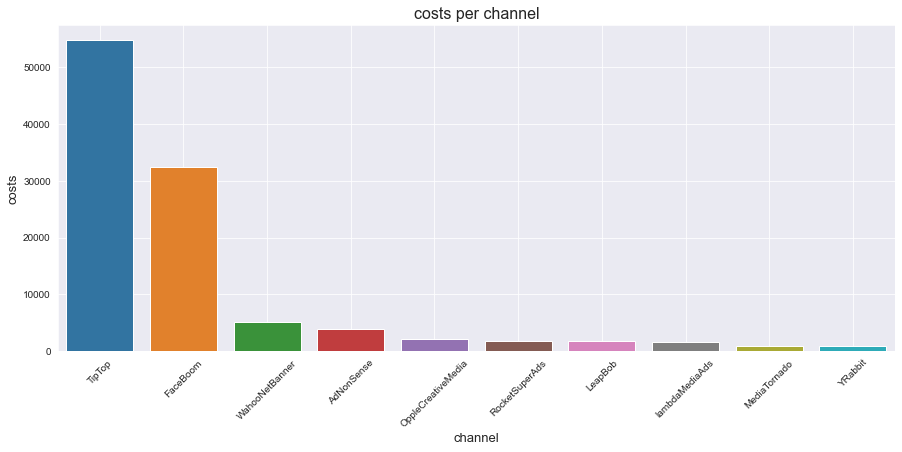

In [22]:
# группируем данные по каналам

channels = (costs
            .pivot_table(index='channel', 
                         values='costs', 
                         aggfunc='sum')
            .sort_values('costs', ascending=False)
            .reset_index()
           )


# визуализируем результат

plt.figure(figsize=(15,6))

sns.barplot(x=channels['channel'], 
            y=channels['costs'])

plt.title('costs per channel', fontsize=16)
plt.xlabel('channel', fontsize=13)
plt.xticks(rotation=45)
plt.ylabel('costs', fontsize=13)
plt.grid()
plt.show()

- За рассматриваемый период больше всего денег было потрачено на каналы "TipTop" и "FaceBoom". 

Посмотрим, как этот показатель менялся во времени:

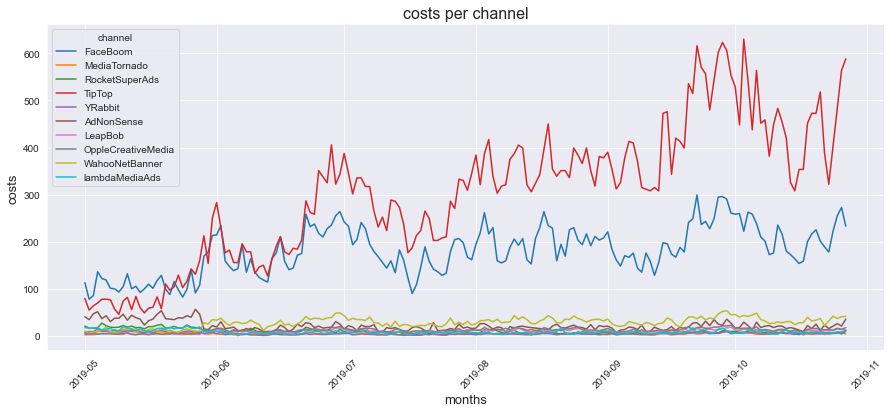

In [23]:
plt.figure(figsize=(15,6))

sns.lineplot(x=costs['dt'], 
             y=costs['costs'], 
             hue=costs['channel'])

plt.title('costs per channel', fontsize=16)
plt.xlabel('months', fontsize=13)
plt.xticks(rotation=45)
plt.ylabel('costs', fontsize=13)
plt.grid()
plt.show()

- Значительный рост затрат во времени показывает только канал "TipTop", все остальные находятся примерно на одном уровне на протяжении расматриваемого периода.

Попробуем соединить эти данные с таблицей с информацией о пользователях из предыдущего этапа:

In [24]:
# соединяем сгруппированные данные о затратах на маркетинг и пользователях

channels = (eda_df('channel')
            .reset_index()
            .merge(channels, on='channel')
            .sort_values('clients', ascending=False)
            .reset_index(drop=True)
           )

# посчитаем стоимость привлечения одного клиента

channels['cac'] = channels['costs']/channels['clients']

In [25]:
# выводим получившуюся таблицу

display(channels)

# посчитаем общую сумму затрат и среднюю стоимость привлечения

print(f"Средняя стоимость привлечения клиента составляет {round(channels['cac'].mean(), 2)}")
print(f"Общая сумма затрат на продвижение составляет {round(channels['costs'].sum(), 2)}")

,channel,clients,payers,payers_share%,costs,cac
0,FaceBoom,29144,3557,12.20,"32,445.60",1.11
1,TipTop,19561,1878,9.60,"54,751.30",2.80
2,OppleCreativeMedia,8605,233,2.71,"2,151.25",0.25
3,WahooNetBanner,8553,453,5.30,"5,151.00",0.60
4,LeapBob,8553,262,3.06,"1,797.60",0.21
5,RocketSuperAds,4448,352,7.91,"1,833.00",0.41
6,MediaTornado,4364,156,3.57,954.48,0.22
7,YRabbit,4312,165,3.83,944.22,0.22
8,AdNonSense,3880,440,11.34,"3,911.25",1.01
9,lambdaMediaAds,2149,225,10.47,"1,557.60",0.72


Средняя стоимость привлечения клиента составляет 0.76
Общая сумма затрат на продвижение составляет 105497.3


____
- Уже сейчас можно сказать, что большие вложения в канал "TipTop" не являются целесообразными - стоимость привлечения клиентов более чем в три раза превышает среднее по всем каналам, а общие расходы составляют почти половину всех рекламных расходов, при том что по доле платящих клиентов канал занимает лишь четвёртое место.


- Помимо "Faceboom", лидирующего по количеству привлечённых клиентов и доле совершающих платежи, стоит также обратить внимание на "lambaMediaAds" - среди каналов-лидеров по доле платящих пользователей этот источник имеют самую низкую стоимость привлечения.

<a id='ad_roi'></a>

## Оценка окупаемости рекламы для привлечения пользователей

На этом этапе мы изучим окупаемость с помощью показателей **LTV**, **ROI**, а также конверсию и удержание пользователей. Согласно вводным данным от заказчика, в корпоративном бизнес-плане затраты на привлечения пользователей должны окупаться в течении двух недель, что необходимо учесть при анализе. Так как цель исследования - оценка окупаемости рекламы, из анализа будут исключены органические пользователи.

In [26]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа

horizon_days = 14  # горизонт анализа

profiles = profiles[profiles['channel'] != 'organic']

### Анализ окупаемости рекламы

Используем [функцию](#funcs) для расчётов показателей и визуализации: 

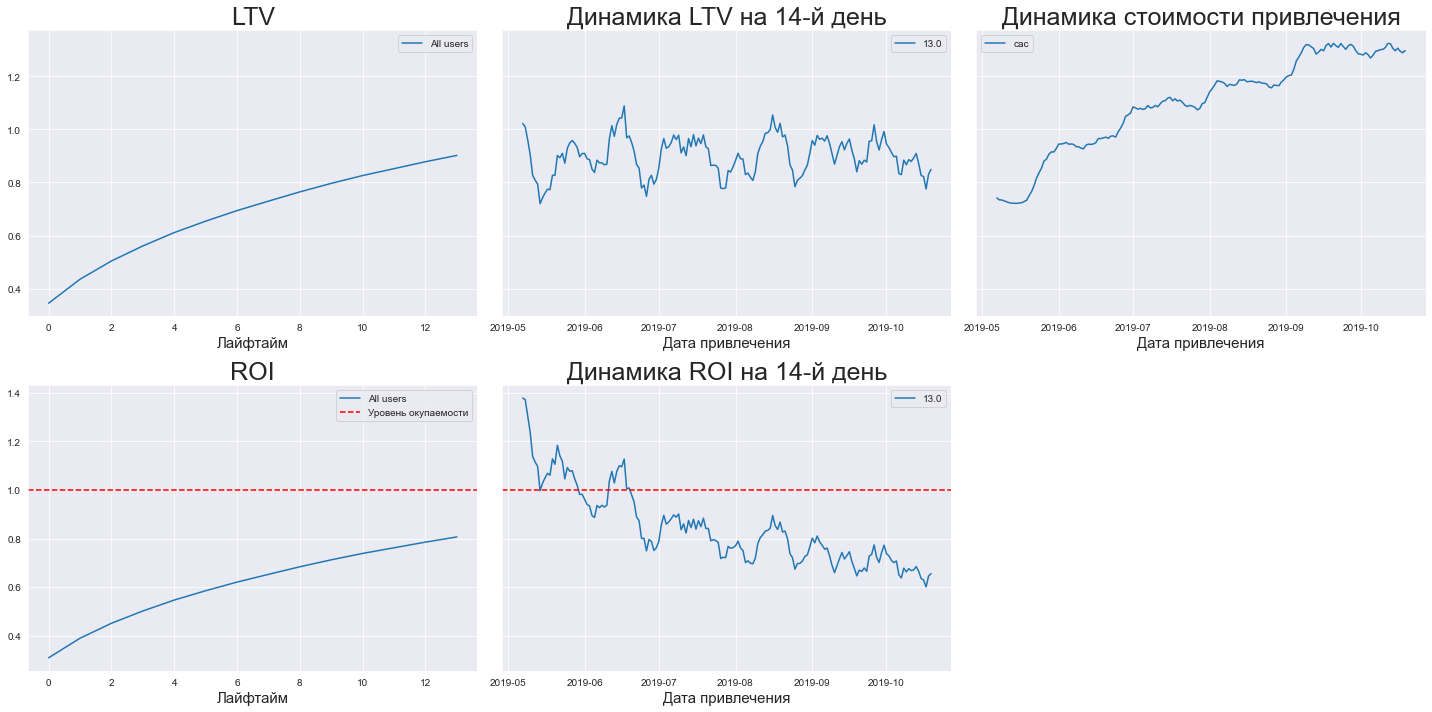

In [27]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

При анализе общих данных можно сделать следующие выводы:
- Привлечение пользователей в целом не окупается за 14 дней.

- Впервые показатель ROI опускается ниже уровня окупаемости в начале июня, в целом отображает стабильное падение.

- С начала июня происходит резкий скачок стоимости привлечения пользователей и постепенно продолжает расти.

- Показатель LTV на 14-ый день колеблется в районе 0.8-1.0 на протяжение всего периода.

Попробуем посмотреть на данные в разрезе регионов:

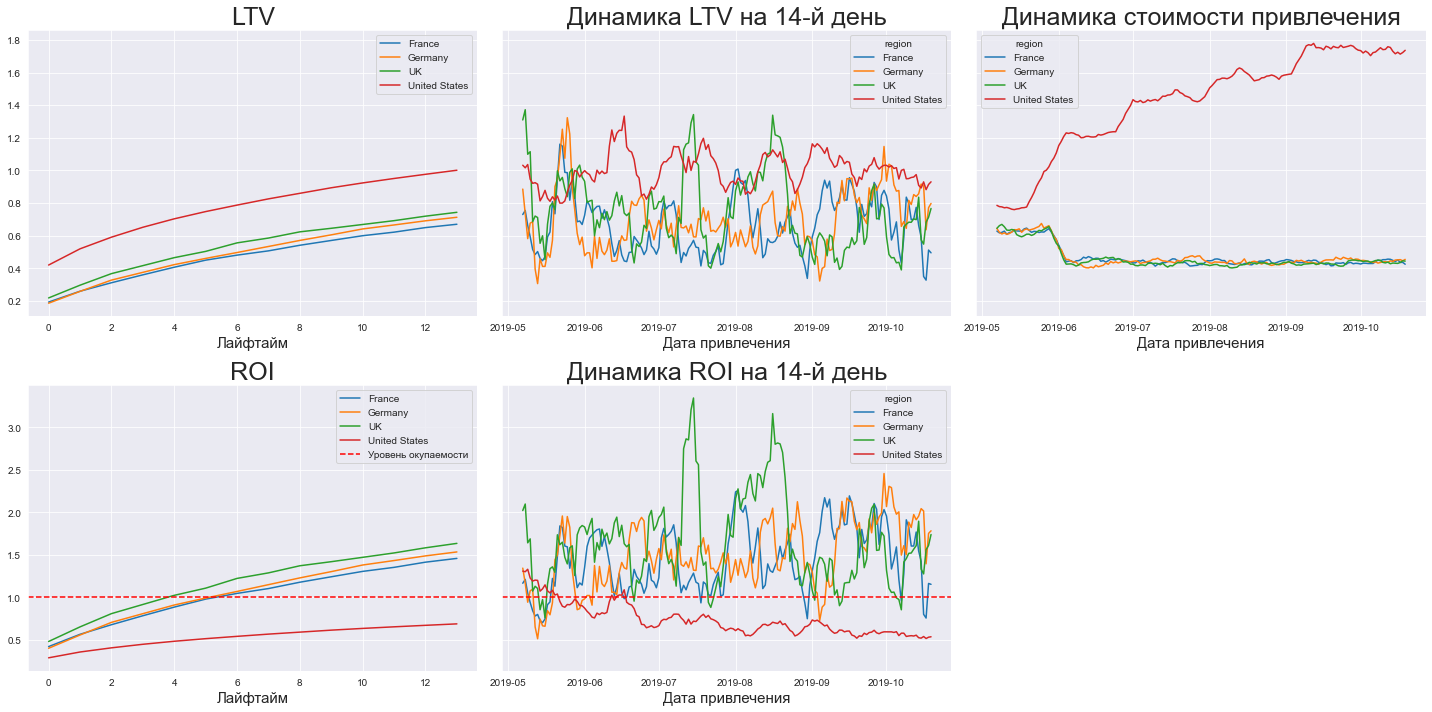

In [28]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# строим графики

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- Линия США идентична графикам по общим данным - скорее всего это обусловлено тем, что в США находится большая часть пользователей приложения, что имеет решающее влияние на формирование трендов. В разрезе регионов видно, что на самом деле лишь пользователи из США показывают отсутсутствие достижения уровня оккупаемости за две недели и резкий рост стоимости привлечения с начала июня. Также именно они проваливаются по динамике ROI на 14-ый день, остальные регионы практически  всегда выше уровня оккупаемости.

Попробуем посмотреть на данные в разрезе используемых устройств:

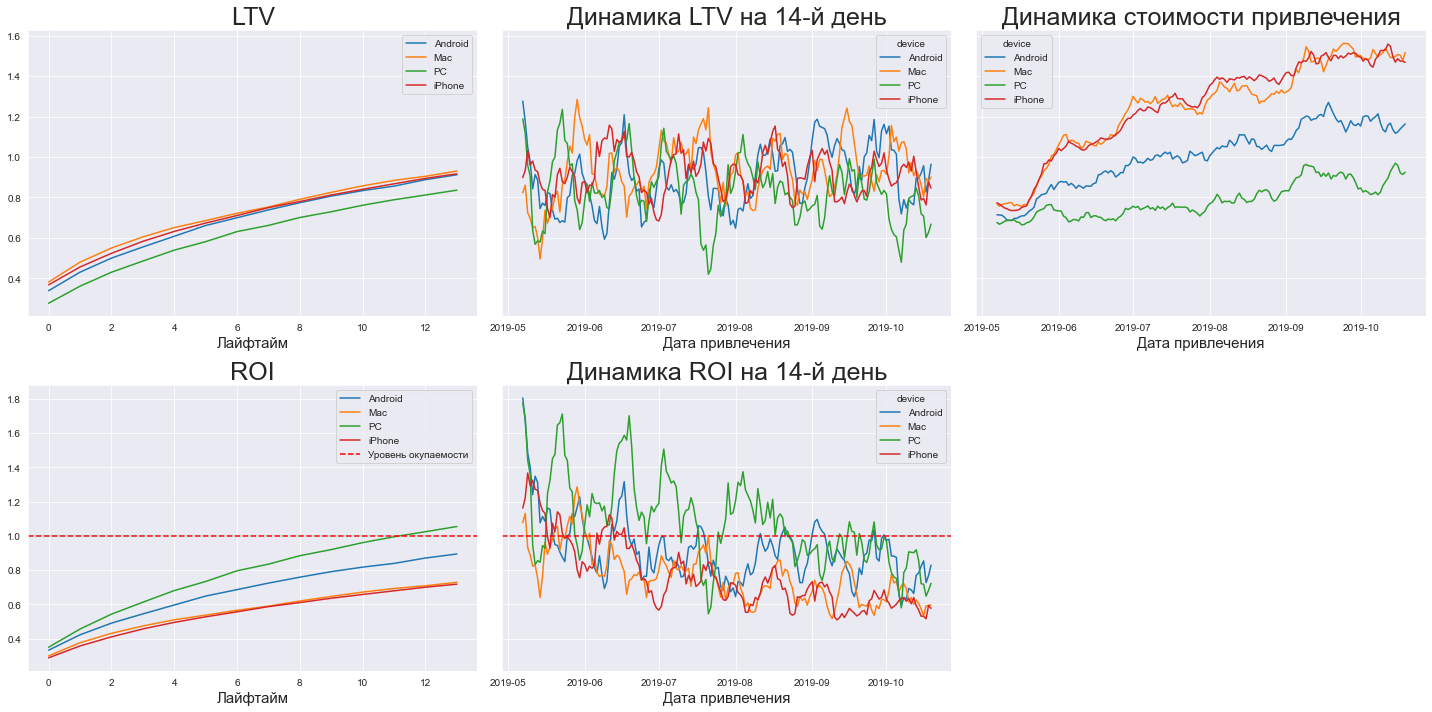

In [29]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

# строим графики

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- Динамика iPhone и Mac практически идентична - несмотря на сравнительно высокий показатель LTV, пользователи этих устройств показывают значительный рост динамики привлечения, что коррелируется с низким ROI и его провалом в динамике на 14-ый день.

- Только пользователи PC в целом достигают уровня окупаемости - возможно стоит пересмотреть функционал и интерфейс приложения на Mac и мобильных устройствах для поиска возможных точек роста.

Посмотрим на данные в разрезе каналов привлечения:

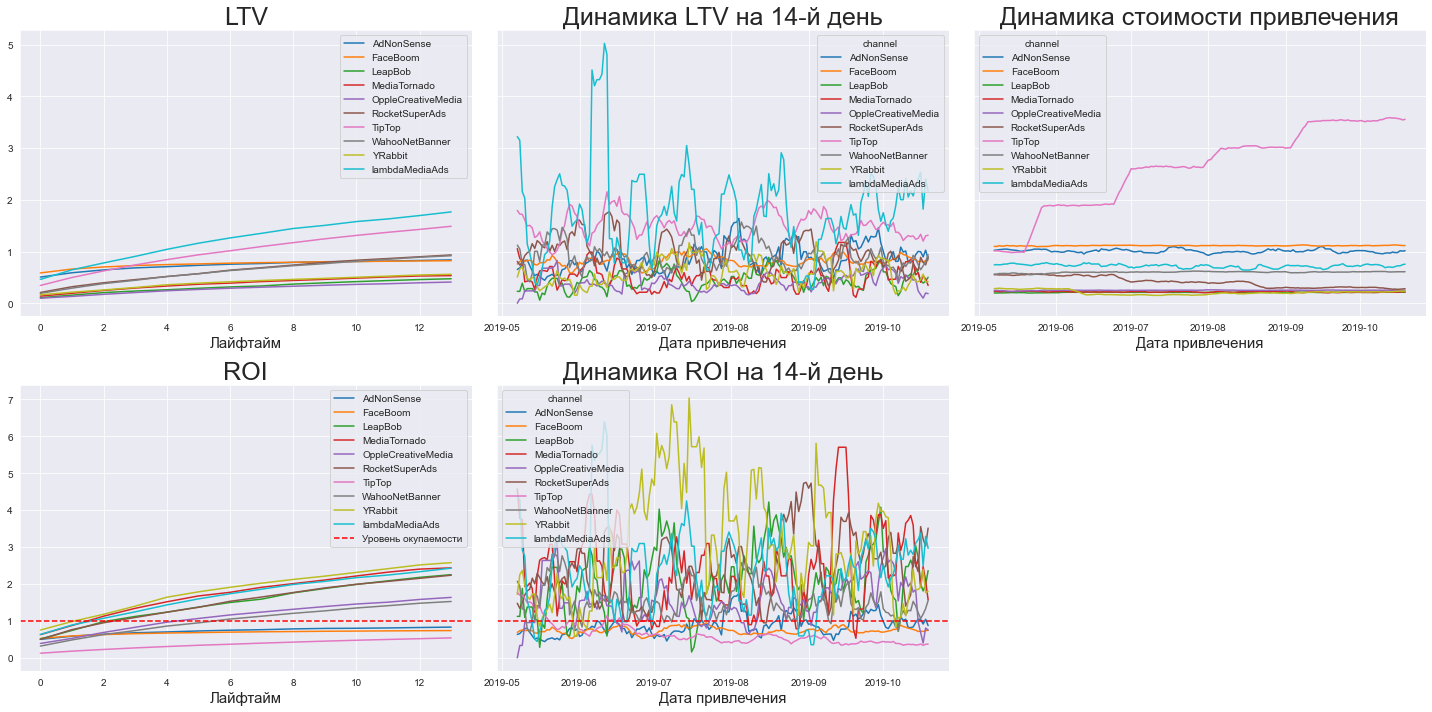

In [30]:
# считаем LTV и ROI

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# строим графики

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- В очередной раз выделяется канал "lambdaMediaAds" - он имеет самый высокий показатель LTV и самую активную динамику по этому показателю на 14-ый день. Уровень окупаемости достигается уже на второй день.


- Все каналы показывают стабильную динамику стоимости привлечения, за исключением "TipTop" - это единственный канал, расходы которого растут во времени.


- Два самых крупных канала по количеству привлечённых пользователей ("TipTop" и "FaceBoom") не достигают уровня оккупаемости.

### Анализ конверсии пользователей

Используем [функцию](#conversion) для расчётов показателей и визуализации, начав с разбивки по регионам: 

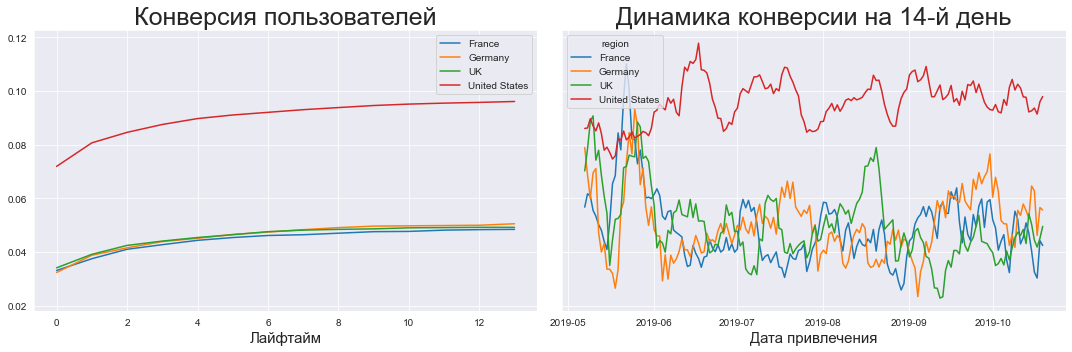

In [31]:
# смотрим конверсию с разбивкой по регионом

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['region']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


- При слабых показателях оккупаемости, пользователи из США показывают стабильно хорошую конверсию, чем и может быть обусловлена высокая доля пользователей из этого региона.

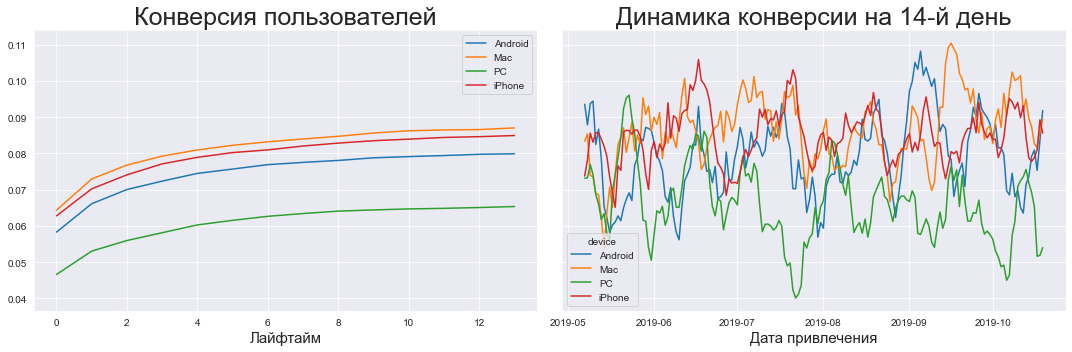

In [32]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


- Пользователи PC показывают самый низкий уровень конверсии - с учётом показателей окупаемости, необходимо поставить в приоритет увеличение этого показателя.

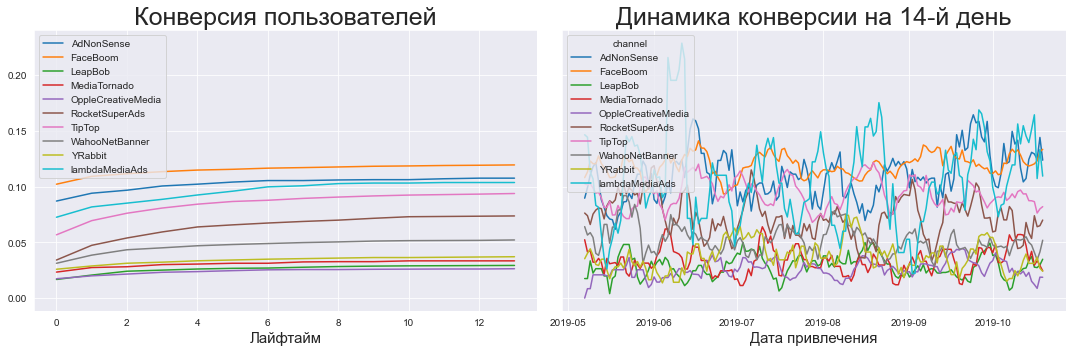

In [33]:
# смотрим конверсию с разбивкой по каналам привлечения

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


- "FaceBoom" показывает самую стабильную и высокую конверсию, а вот показатели "TipTop" - одни из самых низких.


- Динамика "lambaMediaAds" на 14-ый день очень активна, но в целом показывает стабильно высокий уровень.

### Анализ удержания пользователей

Используем [функцию](#retention) для расчётов показателей и визуализации: 

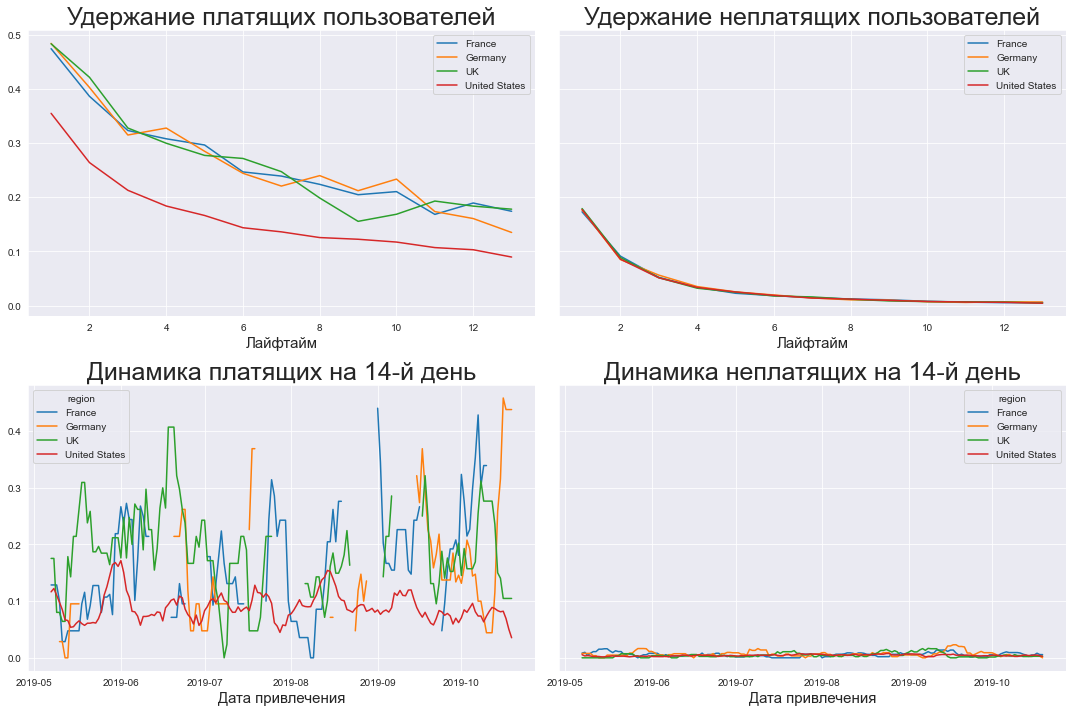

In [34]:
# смотрим удержание с разбивкой по регионам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['region']
)

plot_retention(retention_grouped, retention_history, horizon_days)

- Показатели США стабильно низкие, и в виду большой доли пользователей из этого региона это задаёт общий негативный тренд.

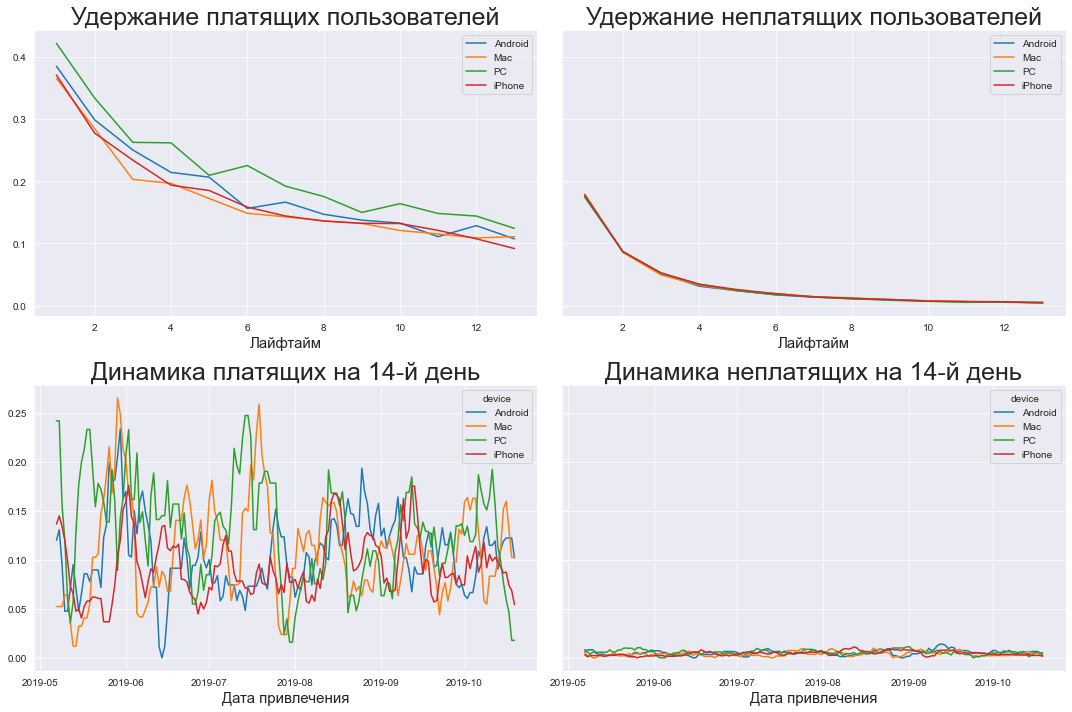

In [35]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Среди устройств по уровню удержания лидирует PC, но в целом все имеют сопоставимые показатели

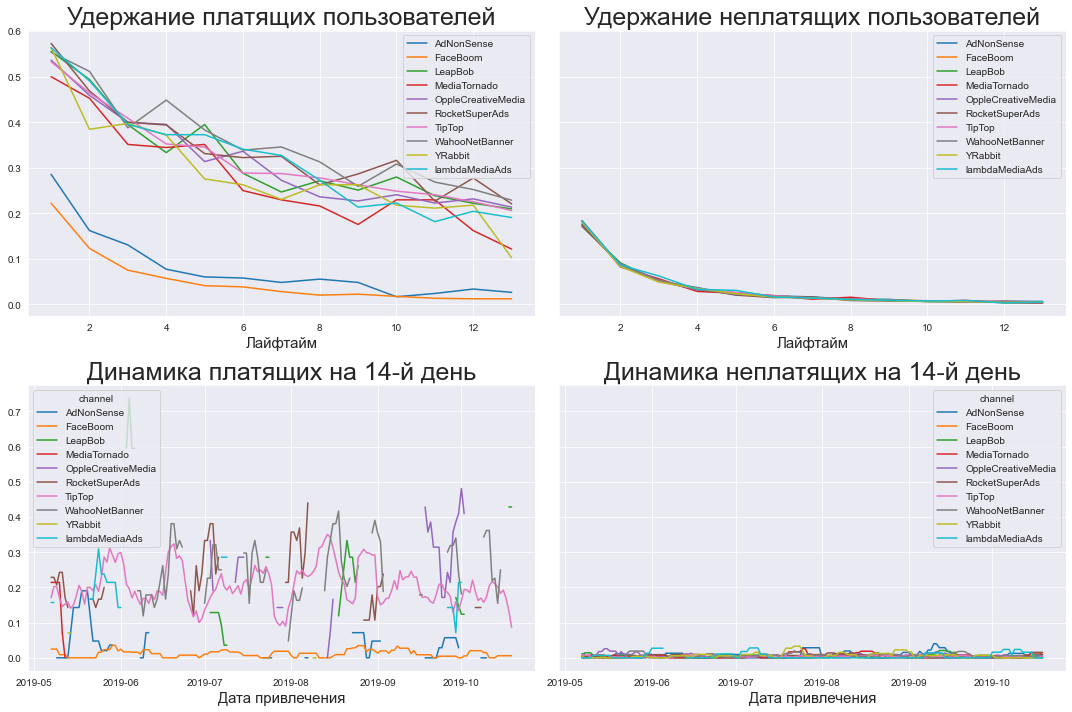

In [36]:
# смотрим удержание с разбивкой по каналам привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Крупнейших канал привлечения по количеству пользователей "FaceBoom" имеет стабильно самые низкий показатель удержания платящих пользователей - с учётом относительно высокой стоимости привлечения одного клиента, это может стать веским поводом для сокращения вложения в этот канал.

<a id='conclusion'></a>

## Общие выводы

----
**Рекомендации**

- От дальнейших вложений в "TipTop" стоит отказаться - суммарные затраты на этот канал привлечения составляет половину рекламного бюджета, но при этом пользователи не достигают уровня оккупаемости за две недели. Несмотря на большое количество пользователей, а также на удовлетворительные показатели конверсии и удержания, канал лишь на четвёртом месте по дол платящих гостей. С учётом текущей показателей, стоимость привлечения вероятно будет продолжать расти со временем, что повлечёт за собой рост убыточности.


- Вложения в "FaceBoom", возможно, стоит сократить - несмотря на первое место по количеству привлёченных пользователей и долей совершающих покупки, этот канал показывает очень низкое удержание платящих пользователей, что при относительно высокой стоимости привлечения одного клиента может стать причиной убытков.


- Одним из самых потенциально прибыльных каналов привлечения является "lambaMediaAds". Все показатели на высоком уровне - одна из самых высоких долей платящих гостей, сравнительно низкая стоимость привлечения, достижение уровня окупаемости уже на второй день, хорошие показатели конверсии и удержания.


- Доля пользователей США на данный момент составляет ~67%, но при этом они имеют самые слабые показатели окупаемости и удержания платящих пользователей - возможно стоит пересмотреть глобальную стратегию продвижения продукта и повысить присутствие в других, более "качественных" регионах.


- Только пользователи PC в целом достигают уровня окупаемости - возможно стоит пересмотреть функционал и интерфейс приложения на Mac и мобильных устройствах для поиска возможных точек роста. Также необходимо поставить приоритет на увеличение конверсии пользователей PC - сейчас в разрезе устройств у них самый низкий показатель.

----

Целью исследования являлось установление причины убыточности развлекательного приложения **Procrastinate Pro+** в последние месяцы. Несмотря на увеличение рекламных расходов, значительный рост количества привлечённых пользователей отсутствует. Необходимо было описать возможные причины обнаруженных проблем и сформировать рекомендации для рекламного отдела. 

**Ход исследования**

Исследование проводилось с использованием лога сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузки их покупок за этот период, а также статистики рекламных расходов.В ходе исследованием было изучено, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей. Исследование было разбито на следующие этапы:

1. [**Обзор/предобработка данных**](#overview)

Были загружены данные о визитах, заказах и расходах в переменные. Данные проверены, дубликатов или пропусков обнаружено не было, типы данных всех столбцов корректные - данные были оптимизированы для дальнейшего анализа.
 
2. [**Написание функций для расчёта бизнес-показателей**](#func)

Были сформированы функции для расчета и анализа показателей **LTV**, **ROI**, **удержания** и **конверсии**, которые были использованы для оценки качества клиентов в дальнейшем исследовании

3. [**Исследовательский анализ данных**](#EDA)

 С помощью функции из предыдущего этапа были сформированы профили пользователей, после чего был проведён анализ в разрезе регионов, используемых устройств и каналов привлечения. Сделаны следующие выводы:

- Данные содержат информацию о пользователях из четырёх регионов - США, Великобритания, Франция и Германия.


- США является крупнейшим рынком пользователей приложения (~67%), а также показывает самую высокую долю платящих пользователей ~7%.


- Данные Европейских регионов сопоставимы - в среднем доля покупателей составляет ~4%. Германия выделятся при этом наименьшим общим количеством клиентов, что делает её показатели наиболее выигрышными. 


- Лидерами по доле покупателей являются устройства компании **Apple** - <a href="https://en.wikipedia.org/wiki/Macintosh">**Mac**</a> и <a href="https://en.wikipedia.org/wiki/iPhone">**iPhone**</a>, их доля превышеает 6.2%. Причём iPhone лидирует с большим отрывом как по количеству общих пользователей, так и по количеству покупателей.


- В разрезе компьютеров <a href="https://en.wikipedia.org/wiki/PC_game">**PC**</a> сильно уступает **Mac** - при практически одинаковом количестве пользователей доля покупателей **PC** сильно ниже.


- Социальная сеть **FaceBoom** является абсолютным лидером по привлечению платящих пользователей - крупнейшая доля покупателей при самом большом количестве всех пользователей (за исключением органики)


- Пользователи, не использующие рекламные ссылки (organic) реже всего становятся покупателями - их доля составляет всего ~2%, при том что таких пользователей больше, чем от любого рекламного источника.

4. [**Анализ маркетинговых действий**](#marketing)

При анализе расходов на рекламу были сделаны следующие выводы:

- Средняя стоимость привлечения клиента составляет 0.76


- Общая сумма затрат на продвижение составляет 105497.3


- За рассматриваемый период больше всего денег было потрачено на каналы "TipTop" и "FaceBoom". 


- Значительный рост затрат во времени показывает только канал "TipTop", все остальные находятся примерно на одном уровне на протяжении расматриваемого периода.


- Уже на данном этапе можно сказать, что большие вложения в канал "TipTop" не являются целесообразными - стоимость привлечения клиентов более чем в три раза превышает среднее по всем каналам, а общие расходы составляют почти половину всех рекламных расходов, при том что по доле платящих клиентов канал занимает лишь четвёртое место.


- Помимо "Faceboom", лидирующего по количеству привлечённых клиентов и доле совершающих платежи, стоит также обратить внимание на "lambaMediaAds" - среди каналов-лидеров по доле платящих пользователей этот источник имеют самую низкую стоимость привлечения.

5. [**Оценка окупаемости рекламы для привлечения пользователей**](#ad_roi)

На этом этапе была изучена окупаемость с помощью показателей **LTV**, **ROI**, а также конверсия и удержания пользователей. Согласно вводным данным от заказчика, в корпоративном бизнес-плане затраты на привлечение пользователей должны окупаться в течении двух недель, что было учтено при анализе. Так как цель исследования - оценка окупаемости рекламы, из анализа были исключены органические пользователи. Все показатели были изучены в разрезе регионов, используемых устройств и каналов привлечения.

**Выводы по анализу окупаемости рекламы**

Общие данные:

- Привлечение пользователей в целом не окупается за 14 дней.


- Впервые показатель ROI опускается ниже уровня окупаемости в начале июня, в целом отображает стабильное падение.


- С начала июня происходит резкий скачок стоимости привлечения пользователей и постепенно продолжает расти.

    
- Показатель LTV на 14-ый день колеблется в районе 0.8-1.0 на протяжение всего периода.

В разрезе регионов:

- Линия США идентична общим графикам по всем регионам - скорее всего это обусловлено тем, что в США находится большая часть пользователей приложения, что имеет решающее влияние на формирование трендов. В разрезе регионов видно, что на самом деле лишь пользователи из США показывают отсутсутствие достижения уровня оккупаемости за две недели и резкий рост стоимости привлечения с начала июня. Также именно они проваливаются по динамике ROI на 14-ый день, остальные регионы практически  всегда выше уровня оккупаемости.

В разрезе используемых устройств:

- Динамика iPhone и Mac практически идентична - несмотря на сравнительно высокий показатель LTV, пользователи этих устройств показывают значительный рост динамики привлечения, что коррелируется с низким ROI и его провалом в динамике на 14-ый день.


- Только пользователи PC в целом достигают уровня окупаемости - возможно стоит пересмотреть функционал и интерфейс приложения на Mac и мобильных устройствах для поиска возможных точек роста.

В разрезе каналов привлечения:

- В очередной раз выделяется канал "lambdaMediaAds" - он имеет самый высокий показатель LTV и самую активную динамику по этому показателю на 14-ый день. Уровень окупаемости достигается уже на второй день.


- Все каналы показывают стабильную динамику стоимости привлечения, за исключением "TipTop" - это единственный канал, расходы которого растут во времени.


- Два самых крупных канала по количеству привлечённых пользователей ("TipTop" и "FaceBoom") не достигают уровня оккупаемости.

**Выводы по анализу конверсии пользователей**

- При слабых показателях оккупаемости, пользователи из США показывают стабильно хорошую конверсию, чем и может быть обусловлена высокая доля пользователей из этого региона.


- Пользователи PC показывают самый низкий уровень конверсии - с учётом показателей окупаемости, необходимо поставить в приоритет увеличение этого показателя.


- "FaceBoom" показывает самую стабильную и высокую конверсию, а вот показатели "TipTop" - одни из самых низких.


- Динамика "lambaMediaAds" на 14-ый день очень активна, но в целом показывает стабильно высокий уровень.

**Выводы по анализу удержания пользователей**:

- Показатели США стабильно низкие, и в виду большой доли пользователей из этого региона это задаёт общий негативный тренд.


- Среди устройств по уровню удержания лидирует PC, но в целом все имеют сопоставимые показатели


- Крупнейших канал привлечения по количеству пользователей "FaceBoom" имеет стабильно самые низкий показатель удержания платящих пользователей - с учётом относительно высокой стоимости привлечения одного клиента, это может стать веским поводом для сокращения вложения в этот канал.